In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 48.05 MiB/s, done.
Resolving deltas: 100% (81/81), done.


The directory SegNet-Tutorial/CamVid is symbolically linked to data/camvid-tiramisu in the terminal.

In [2]:
path = Path('./data/camvid-tiramisu/')

In [3]:
path.ls()

[PosixPath('data/camvid-tiramisu/test.txt'),
 PosixPath('data/camvid-tiramisu/train.txt'),
 PosixPath('data/camvid-tiramisu/val'),
 PosixPath('data/camvid-tiramisu/testannot'),
 PosixPath('data/camvid-tiramisu/test'),
 PosixPath('data/camvid-tiramisu/train'),
 PosixPath('data/camvid-tiramisu/trainannot'),
 PosixPath('data/camvid-tiramisu/val.txt'),
 PosixPath('data/camvid-tiramisu/models'),
 PosixPath('data/camvid-tiramisu/valannot')]

## Data

In [4]:
fnames = get_image_files(path/'val')

In [5]:
lbl_names = get_image_files(path/'valannot')

In [6]:
fnames[:3], len(fnames)

([PosixPath('data/camvid-tiramisu/val/0016E5_08121.png'),
  PosixPath('data/camvid-tiramisu/val/0016E5_08061.png'),
  PosixPath('data/camvid-tiramisu/val/0016E5_08099.png')],
 101)

In [7]:
lbl_names[:3], len(lbl_names)

([PosixPath('data/camvid-tiramisu/valannot/0016E5_08121.png'),
  PosixPath('data/camvid-tiramisu/valannot/0016E5_08061.png'),
  PosixPath('data/camvid-tiramisu/valannot/0016E5_08099.png')],
 101)

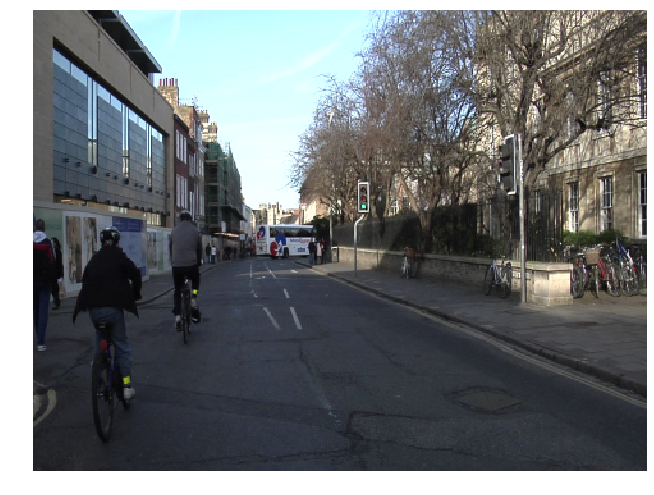

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(11, 10))

In [6]:
def get_y_fn(x): return Path(str(x.parent) + 'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree', 'Sign',
              'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [7]:
codes

array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree', 'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'],
      dtype='<U10')

In [10]:
mask = open_mask(get_y_fn(img_f))

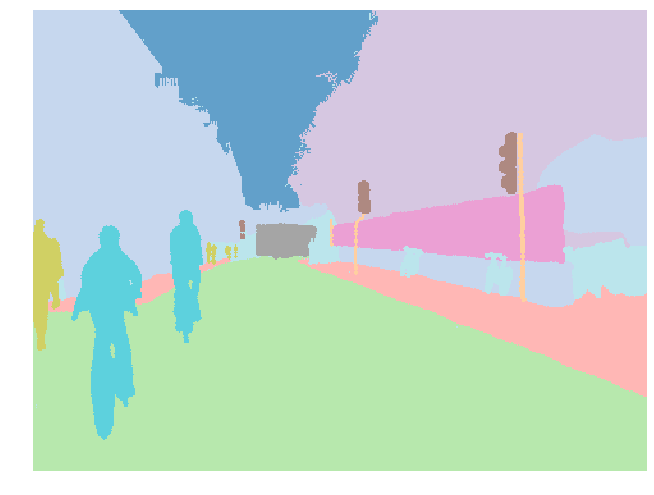

In [11]:
mask.show(figsize=(11, 10), alpha=.7)

In [12]:
src_size = np.array(mask.shape[1:])

In [13]:
src_size, mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [14]:
bs, size = 4, src_size // 2

In [15]:
src = (SegmentationItemList
       .from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src
       .transform(get_transforms(), tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

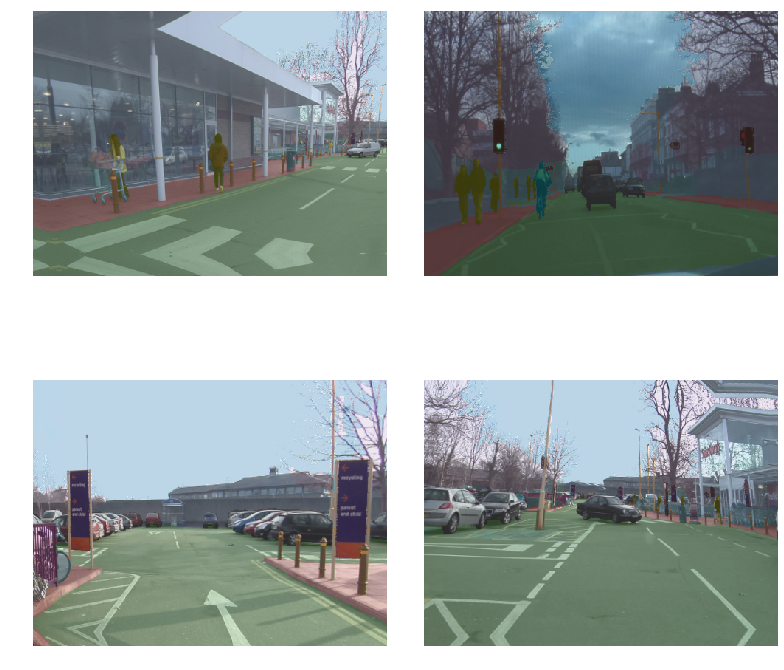

In [35]:
data.show_batch(rows=2, figsize=(11, 11), alpha=.3)

## Model

In [17]:
name2id = {v:n for n,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [18]:
metrics = acc_camvid
wd = 1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


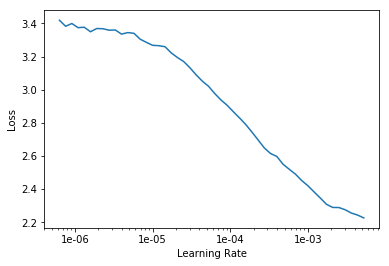

In [49]:
learn.recorder.plot()

In [24]:
lr = 2e-3

In [51]:
learn.fit_one_cycle(cyc_len=10, max_lr=slice(lr), pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.887890,0.663625,0.793433,00:59
2,0.670913,0.563707,0.848526,00:57
3,0.533504,0.497201,0.842396,00:58
4,0.549470,0.506533,0.873396,00:58
5,0.496552,0.425216,0.882788,00:58
6,0.569766,0.557638,0.839202,00:58
7,0.454937,0.411394,0.883761,00:57
8,0.423693,0.376049,0.896302,00:57
9,0.359984,0.329915,0.892041,00:57
10,0.305871,0.279231,0.915710,00:57


In [52]:
learn.save('stage-1')

In [20]:
learn.load('stage-1');

In [22]:
learn.unfreeze()

In [25]:
lrs = slice(lr / 100, lr)

In [26]:
learn.fit_one_cycle(cyc_len=12, max_lr=lrs, pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.281198,0.274542,0.912532,01:10
2,0.274703,0.274560,0.915780,00:59
3,0.267971,0.266317,0.918620,00:59
4,0.280532,0.359230,0.892378,01:00
5,0.282341,0.271476,0.919367,01:00
6,0.300548,0.311927,0.909017,01:00
7,0.304191,0.273100,0.918150,01:00
8,0.317030,0.314413,0.909205,01:00
9,0.310008,0.311049,0.910100,01:00
10,0.300702,0.290100,0.913700,01:01


In [27]:
learn.save('stage-2')

## Go Big

In [28]:
learn=None

In [30]:
gc.collect()

3173

In [31]:
bs, size = 4, src_size

In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [34]:
learn.load('stage-2');

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


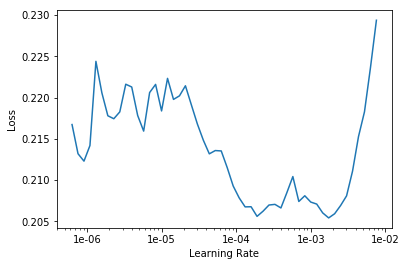

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-3), pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.213064,0.237578,0.930035,00:55
2,0.202640,0.261761,0.924834,00:56
3,0.203362,0.255045,0.924422,00:57
4,0.203176,0.276214,0.919622,00:58
5,0.201936,0.233596,0.934691,00:58
6,0.205313,0.240519,0.934813,00:58
7,0.199656,0.255534,0.931918,00:58
8,0.203992,0.266590,0.926112,00:58
9,0.194045,0.245387,0.935689,00:58
10,0.174094,0.234005,0.934408,00:58


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big');

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(1e-3/1000, 1e-3/10)

In [42]:
learn.fit_one_cycle(cyc_len=10, max_lr=lrs)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.159141,0.239559,0.934230,00:59
2,0.162094,0.256104,0.931819,01:00
3,0.165339,0.260314,0.932751,01:01
4,0.163627,0.246767,0.933290,01:02
5,0.158760,0.251314,0.933615,01:02
6,0.156575,0.259965,0.932198,01:02
7,0.154382,0.253640,0.933436,01:02
8,0.153282,0.252674,0.933865,01:02
9,0.154468,0.250922,0.934175,01:02
10,0.152529,0.251159,0.934493,01:02


In [43]:
learn.save('stage-2-big')

In [45]:
learn.load('stage-2-big');

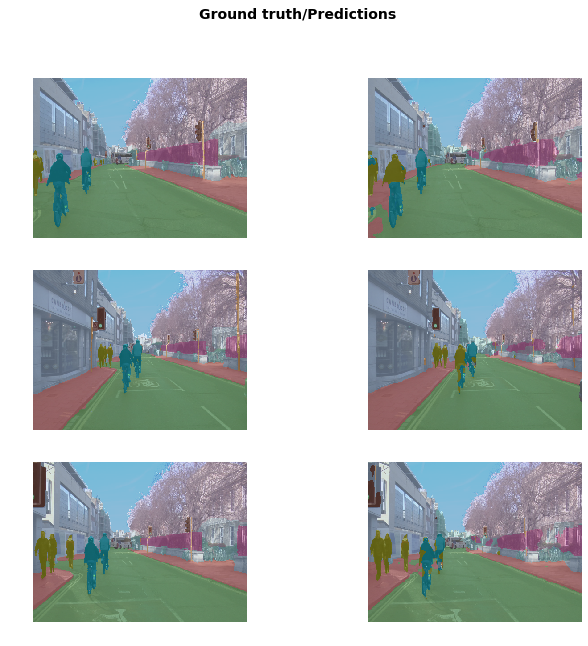

In [47]:
learn.show_results(rows=3, figsize=(11,10))

In [51]:
bs

4

In [50]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 180, 240]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [1, 64, 90, 120]     36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [1, 64, 90, 120]     0          False     
______________________________________________________________